In [1]:

import base64
import numpy as np
import pandas as pd
# Plotly imports
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


# Other imports
from collections import Counter
import cv2
#from scipy.misc.pilutil import imread
#from imread import imread
#from scipy.misc import imread
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib import pyplot as plt
%matplotlib inline

import nltk
import re
from pprint import pprint
import spacy  ## spacy is their for lemmatization

# Plotting tools
import pyLDAvis
#import pyLDAvis.gensim
import matplotlib.pyplot as plt




# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [27]:
train=pd.read_csv('Usecase3_Dataset.csv')

## Exploratory Data Analysis

In [28]:
train.head()

,airline_sentiment,airline,text
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...
3,negative,Virgin America,@VirginAmerica it's really aggressive to blast...
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing...


In [50]:
Virgin_America=train[train.airline=="Virgin America"]["text"].value_counts

In [53]:
train.describe()

,airline_sentiment,airline,text
count,14640,14640,14640
unique,3,6,14427
top,negative,United,@united thanks
freq,9178,3822,6


In [56]:
temp = train.groupby('airline_sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,airline_sentiment,text
0,negative,9178
1,neutral,3099
2,positive,2363


In [58]:
fig = go.Figure(go.Funnelarea(
    text =temp.airline_sentiment,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

In [62]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [63]:
results_jaccard=[]

for ind,row in train.iterrows():
    sentence1 = row.text
    sentence2 = row.selected_text

    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

AttributeError: 'Series' object has no attribute 'selected_text'

In [59]:
train['temp_list'] = train['selected_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

KeyError: 'selected_text'

In [52]:
Virgin_America

<bound method IndexOpsMixin.value_counts of 0                    @VirginAmerica What @dhepburn said.
1      @VirginAmerica plus you've added commercials t...
2      @VirginAmerica I didn't today... Must mean I n...
3      @VirginAmerica it's really aggressive to blast...
4      @VirginAmerica and it's a really big bad thing...
                             ...                        
499    @VirginAmerica morning. If I have a question r...
500    @VirginAmerica still waiting to see  @Starryey...
501    @VirginAmerica was wondering if you guys recie...
502    @VirginAmerica Flying LAX to SFO and after loo...
503    “@VirginAmerica: Book out of town with fares f...
Name: text, Length: 504, dtype: object>

In [13]:
train['airline'].unique

<bound method Series.unique of 0        Virgin America
1        Virgin America
2        Virgin America
3        Virgin America
4        Virgin America
              ...      
14635          American
14636          American
14637          American
14638          American
14639          American
Name: airline, Length: 14640, dtype: object>

In [47]:
train.dtypes

airline_sentiment    object
airline              object
text                 object
dtype: object

In [48]:
train['word_count'] = train['text'].apply(lambda x : len(x.split()))
train['char_count'] = train['text'].apply(lambda x : len(x.replace(" ","")))
train['word_density'] = train['word_count'] / (train['char_count'] + 1)
#train['text'] = train['text'].apply(lambda x : len([a for a in x if a in text]))

train[['word_count', 'char_count', 'word_density']].head(5000)

,word_count,char_count,word_density
0,4,32,0.121212
1,9,64,0.138462
2,12,60,0.196721
3,17,110,0.153153
4,10,46,0.212766
...,...,...,...
4995,5,32,0.151515
4996,29,103,0.278846
4997,15,88,0.168539
4998,17,120,0.140496


In [49]:
z = {'Virgin America': 'Delta', 'United': 'US Airways', 'Southwest': 'American'}
data = [go.Bar(
            x = train.airline.map(z).unique(),
            y = train.airline.value_counts().values,
            marker= dict(colorscale='Jet',
                         color = train.airline.value_counts().values
                        ),
            text='Text entries attributed to airline'
    )]

layout = go.Layout(
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [50]:
all_words = train['text'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the training dataset'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [7]:
Virgin_America=train[train.airline=="Virgin America"]["text"].values
United = train[train.airline=="United"]["text"].values
Southwest = train[train.airline=="Southwest"]["text"].values
Delta= train[train.airline=="Delta"]["text"].values
American= train[train.airline=="American"]["text"].values
US_Airways= train[train.airline=="US Airways"]["text"].values


AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

## NLP ## 
In almost all Natural Language Processing (the field that explores interactions between a computer and human languages) tasks that you will come across (be it topic modelling, or word clustering or document-text classification etc), one will generally always have to undergo these few pre-processing steps to convert the input raw text into a form that is readable by your model and the machine. You certainly can't expect to feed a Random Forest model a paragraph of words and expect it to immediately predict which author that paragraph came from. Behind the scenes, text pre-processing can be boiled down to these few simple steps:

Tokenization - Segregation of the text into its individual constitutent words.
Stopwords - Throw away any words that occur too frequently as its frequency of occurrence will not be useful in helping detecting relevant texts. (as an aside also consider throwing away words that occur very infrequently).
Stemming - combine variants of words into a single parent word that still conveys the same meaning
Vectorization - Converting text into vector format. One of the simplest is the famous bag-of-words approach, where you create a matrix (for each document or text in the corpus). In the simplest form, this matrix stores word frequencies (word counts) and is oft referred to as vectorization of the raw text.
Natural Language Toolkit (NLTK): To make our Natural Language Processing endeavours more convenient, let me introduce to you one of the most handy toolkits that on NLP - the Natural Language Toolkit, also more commonly referred to as the NLTK module. To import the toolkit, it is as easier as:

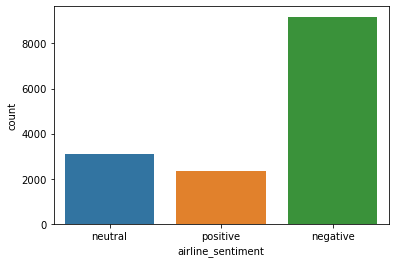

In [19]:
sns.countplot(data=df, x="airline_sentiment");


In [ ]:
##Maximum feedback belongs to negative sentiment

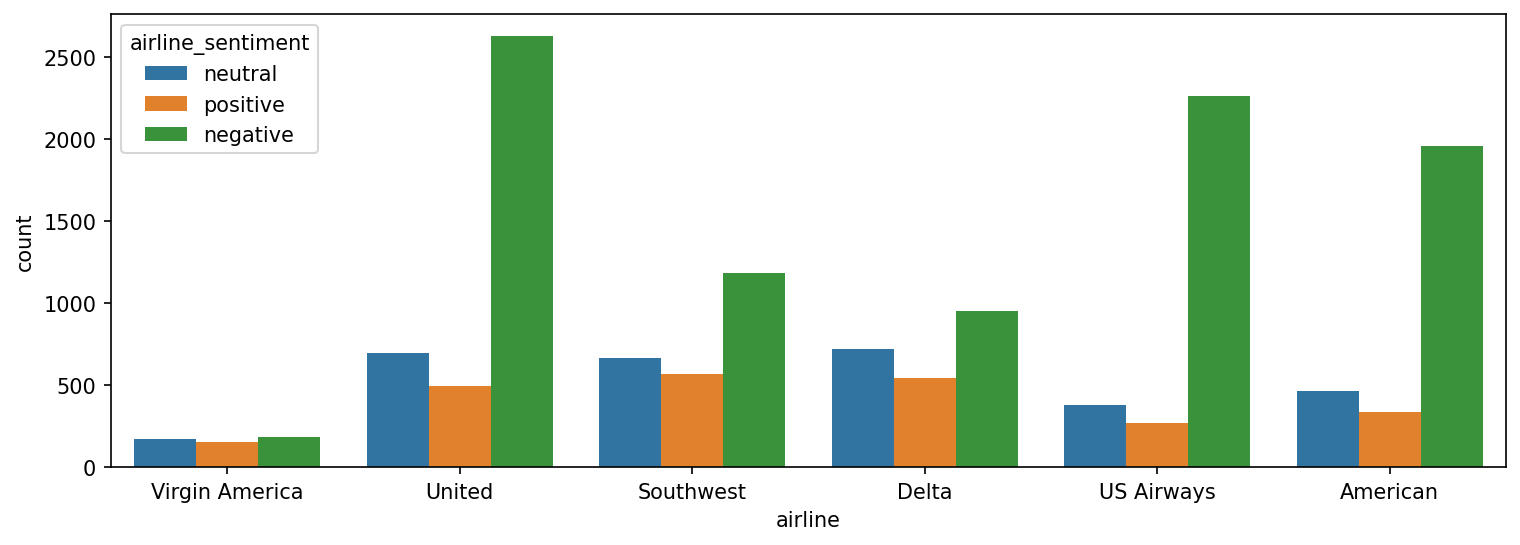

In [22]:
plt.figure(figsize=(12, 4), dpi=150)
sns.countplot(data=df, x="airline", hue="airline_sentiment");

In [54]:
data = df[["airline_sentiment", "text"]]
data.head()
df=pd.read_csv('Usecase3_Dataset.csv')

In [ ]:
##Maximum negative feedback can be observed in United Airlines and US Airways among all the airlines

In [55]:
X = df["text"]
y = df["airline_sentiment"]

In [56]:
from sklearn.model_selection import train_test_split
Xtrain, Xvalid, ytrain, yvalid = train_test_split(X, y, test_size=0.2, random_state=101)

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


In [58]:
tfidf = TfidfVectorizer(stop_words="english")

In [59]:
tfidf.fit(Xtrain)

TfidfVectorizer(stop_words='english')

In [60]:
print(tfidf.vocabulary_)

{'united': 12022, 'hi': 6014, 'relative': 9648, 'flight': 5168, 'booking': 2645, 'problems': 9187, 'number': 8319, 'my8yb4': 7968, 'clarita': 3269, 'jaramillo': 6689, 'mejia': 7657, 'thank': 11341, 'americanair': 1889, 'served': 10313, 'nastiest': 8035, 'food': 5293, 'ive': 6645, 'seen': 10262, 'yesterday': 12872, 'rubber': 10005, 'chicken': 3192, 'slime': 10566, 'entire': 4690, 'cabin': 2900, 'sent': 10294, 'fas': 4986, 'confirm': 3525, 'yes': 12869, 'partly': 8684, 'used': 12189, 'del': 4000, 'ewr': 4799, 'return': 9835, 'cancelled': 2947, 'flightled': 5197, 'technical': 11273, 'glitch': 5630, 'operations': 8479, 'jetblue': 6725, 'helping': 5989, 'bunch': 2828, 'trying': 11717, 'time': 11472, 'fly': 5239, 'terrible': 11311, 'service': 10316, 'ruined': 10013, 'vacation': 12231, 'lostsuitcase': 7341, 'noreimbursement': 8246, 'usairways': 12170, '2hrs': 593, 'late': 7048, 'flightr': 5205, 'finally': 5096, 'taking': 11213, 'new': 8118, 'big': 2524, 'fan': 4971, 'southwestair': 10715, 'se

In [61]:
data[data["airline_sentiment"]=="negative"]["text"]

3        @VirginAmerica it's really aggressive to blast...
4        @VirginAmerica and it's a really big bad thing...
5        @VirginAmerica seriously would pay $30 a fligh...
15           @VirginAmerica SFO-PDX schedule is still MIA.
17       @VirginAmerica  I flew from NYC to SFO last we...
                               ...                        
14631    @AmericanAir thx for nothing on getting us out...
14633    @AmericanAir my flight was Cancelled Flightled...
14634           @AmericanAir right on cue with the delays👌
14636    @AmericanAir leaving over 20 minutes Late Flig...
14638    @AmericanAir you have my money, you change my ...
Name: text, Length: 9178, dtype: object

In [62]:
count_vect = CountVectorizer(stop_words="english")
neg_matrix = count_vect.fit_transform(data[data["airline_sentiment"]=="negative"]["text"])
freqs = zip(count_vect.get_feature_names(), neg_matrix.sum(axis=0).tolist()[0])
# Sort from largest to smallest
print(sorted(freqs, key=lambda x: -x[1])[:100])

[('flight', 2943), ('united', 2899), ('usairways', 2375), ('americanair', 2110), ('southwestair', 1214), ('jetblue', 1052), ('cancelled', 926), ('service', 750), ('hours', 649), ('just', 622), ('help', 619), ('customer', 614), ('hold', 614), ('time', 598), ('plane', 532), ('delayed', 508), ('amp', 503), ('hour', 452), ('flightled', 448), ('http', 437), ('bag', 420), ('flights', 420), ('gate', 411), ('ve', 399), ('don', 388), ('late', 378), ('need', 373), ('phone', 369), ('waiting', 341), ('thanks', 315), ('got', 299), ('airline', 294), ('like', 292), ('trying', 288), ('delay', 273), ('wait', 272), ('today', 269), ('minutes', 267), ('going', 252), ('day', 251), ('bags', 245), ('luggage', 245), ('told', 245), ('airport', 244), ('people', 243), ('worst', 241), ('fly', 239), ('really', 236), ('did', 227), ('guys', 225), ('weather', 224), ('lost', 221), ('agent', 220), ('hrs', 217), ('way', 215), ('make', 211), ('change', 210), ('seat', 208), ('flighted', 205), ('want', 205), ('check', 204)

In [63]:
#Wordcloud

In [64]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(data[data["airline_sentiment"]=="negative"]["text"]))

In [65]:
Xtrain_tfidf = tfidf.transform(Xtrain)
Xvalid_tfidf = tfidf.transform(Xvalid)

In [66]:
Xtrain_tfidf.toarray().shape

(11712, 12971)

In [67]:
#Modelling

In [68]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(Xtrain_tfidf, ytrain)

MultinomialNB()

In [69]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=10000)
lr.fit(Xtrain_tfidf, ytrain)

LogisticRegression(max_iter=10000)

In [70]:
from sklearn.svm import SVC, LinearSVC

rbf_svc = SVC()
rbf_svc.fit(Xtrain_tfidf, ytrain)


SVC()

In [71]:
linear_svc = LinearSVC()
linear_svc.fit(Xtrain_tfidf, ytrain)


LinearSVC()

In [72]:
from sklearn.metrics import plot_confusion_matrix, classification_report

In [73]:
def report(model):
    preds = model.predict(Xvalid_tfidf)
    print(classification_report(yvalid, preds))
    plot_confusion_matrix(model, Xvalid_tfidf, yvalid)

              precision    recall  f1-score   support

    negative       0.66      0.99      0.79      1817
     neutral       0.79      0.15      0.26       628
    positive       0.89      0.14      0.24       483

    accuracy                           0.67      2928
   macro avg       0.78      0.43      0.43      2928
weighted avg       0.73      0.67      0.59      2928



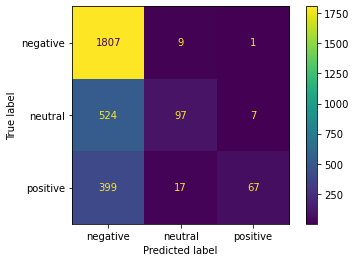

In [74]:
report(nb)

              precision    recall  f1-score   support

    negative       0.80      0.93      0.86      1817
     neutral       0.63      0.47      0.54       628
    positive       0.82      0.58      0.68       483

    accuracy                           0.77      2928
   macro avg       0.75      0.66      0.69      2928
weighted avg       0.77      0.77      0.76      2928



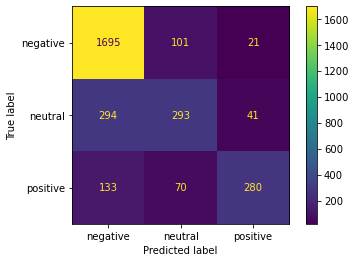

In [75]:
report(lr)

              precision    recall  f1-score   support

    negative       0.78      0.95      0.86      1817
     neutral       0.67      0.41      0.51       628
    positive       0.81      0.56      0.66       483

    accuracy                           0.77      2928
   macro avg       0.75      0.64      0.67      2928
weighted avg       0.76      0.77      0.75      2928



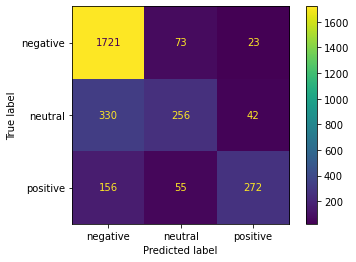

In [76]:
report(rbf_svc)

G:\Anaconda_install\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



              precision    recall  f1-score   support

    negative       0.82      0.89      0.86      1817
     neutral       0.59      0.52      0.55       628
    positive       0.76      0.64      0.69       483

    accuracy                           0.77      2928
   macro avg       0.73      0.68      0.70      2928
weighted avg       0.76      0.77      0.77      2928



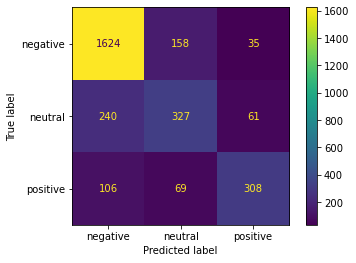

In [28]:
report(linear_svc)

In [29]:
from sklearn.pipeline import Pipeline


G:\Anaconda_install\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [30]:
pipe = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("rbf_svc", SVC())
])

pipe.fit(X, y)

G:\Anaconda_install\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Pipeline(steps=[('tfidf', TfidfVectorizer()), ('rbf_svc', SVC())])

In [ ]:
#Predicting feedbacks and classifying based on the training data

In [31]:
pipe.predict(["The flight went really quick"])

G:\Anaconda_install\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



array(['positive'], dtype=object)

In [32]:
pipe.predict(["This flight wasn't very good experience"])

G:\Anaconda_install\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



array(['negative'], dtype=object)

In [37]:
pipe.predict(["happy"])

G:\Anaconda_install\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



array(['positive'], dtype=object)